# Create Keypoints Dataset

In this notebook we are going to make our own pose classification dataset in a csv format, which we can then use to train a pose classifier.

The csv file will be created by extracting the keypoints (x, y coordinates of every body landmark) from images that contain human body poses. 

Therefore, the primary material we need to work with, is images. There are many ways to collect images for that cause:

- Use the `00-collect-images-from-webcam` python script

- Download public image datasets from Kaggle, eg. [yoga pose image dataset](https://www.kaggle.com/datasets/ujjwalchowdhury/yoga-pose-classification) and organise them in the respective folder

- Record videos of yourself or others (as long as you have their consent) performing specific poses each time, and then use `ffmpeg` to extract the frames for each class. This process will return folders of frames, similar to what you get from option 1. Some quick instructions for `ffmpeg`:

Download it from [here](https://ffmpeg.org/download.html)
Then, open the terminal, move into the directory (cd PATH) where you have the video you want to transform into frames, create a folder to save your frames in it and run the command:

`ffmpeg -i file_name.mov -r 1 -s WxH -f image2 folder_name/%03d.jpeg`

This will extract one video frame per second from the video and will output them in files named 001.jpeg, 002.jpeg, etc. Images will be rescaled to fit the new WxH values (you can skipp -s WxH if you do not wish to resize your images). Look [here](https://ffmpeg.org/ffmpeg.html) for more information on `ffmpeg`.

### Setting up your Python environment

Before you work through this notebook, please follow the instructions in [Setup-and-test-conda-environment.ipynb](Setup-and-test-conda-environment.ipynb)

Once you have done that you will need to make sure that the environment selected to run this notebook and all the other notebooks used in this unit is called `aim`. 

To do this click the **Select kernel** button in the top right corner of this notebook, and then select `aim`.

To make sure that is configured properly, Hit the run cell button (▶) on the cell below:

In [1]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

aim


Does it output the text `aim`?

If it does not output the text `aim`, please revisit and follow the instructions in [Setup-and-test-conda-environment.ipynb](Setup-and-test-conda-environment.ipynb).

If you still cannot get it working, please raise this with the course instructor. 

## Call and Test Yolov8-Pose to Extract Keypoints from Image

Code adapted from this [repo](https://github.com/Alimustoofaa/YoloV8-Pose-Keypoint-Classification/tree/master).

First let's do some imports:

In [2]:
import cv2
import os
import glob
import csv
import pandas as pd
from PIL import Image
from pydantic import BaseModel
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/griffinkoo/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


If the previous cell returns an error, uncomment the next line and run it to install pydantic

In [3]:
# !pip install pydantic

##### Download and save the pre-trained model YOLO for pose estimation

In [4]:
model = YOLO(model='yolov8m-pose.pt')

##### List out the names of our classes/labels in your dataset folder

In [5]:
# You might want to rename your folders with more meaningful names if they are currently named with numbers
# You can do that manually and then re-run this cell to see all your names listed
!ls .class-datasets/my-pose-classification-dataset

ls: .class-datasets/my-pose-classification-dataset: No such file or directory


##### Select a sample image from our dataset and apply the keypoint predictions from YOLO on it

In [6]:
image = cv2.imread('.class-datasets/my-pose-classification-dataset/2/15.jpg')
result = model.predict(image, save=False)[0]
result.keypoints[0]

WARNING ⚠️ 'source' is missing. Using 'source=/opt/miniconda3/envs/aim/lib/python3.13/site-packages/ultralytics/assets'.



[ WARN:0@95.180] global loadsave.cpp:275 findDecoder imread_('.class-datasets/my-pose-classification-dataset/2/15.jpg'): can't open/read file: check file path/integrity


image 1/2 /opt/miniconda3/envs/aim/lib/python3.13/site-packages/ultralytics/assets/bus.jpg: 640x480 5 persons, 176.8ms
image 2/2 /opt/miniconda3/envs/aim/lib/python3.13/site-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 112.1ms
Speed: 2.2ms preprocess, 144.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


ultralytics.engine.results.Keypoints object with attributes:

conf: tensor([[0.9752, 0.9137, 0.9343, 0.6084, 0.7299, 0.9871, 0.9885, 0.9550, 0.9631, 0.9365, 0.9416, 0.9858, 0.9867, 0.9523, 0.9540, 0.7999, 0.7985]])
data: tensor([[[1.3928e+02, 4.4326e+02, 9.7517e-01],
         [1.4721e+02, 4.3415e+02, 9.1368e-01],
         [1.2850e+02, 4.3394e+02, 9.3426e-01],
         [1.5309e+02, 4.4234e+02, 6.0838e-01],
         [1.0587e+02, 4.4107e+02, 7.2991e-01],
         [1.6686e+02, 4.9804e+02, 9.8712e-01],
         [8.9080e+01, 4.9770e+02, 9.8849e-01],
         [1.9118e+02, 5.7493e+02, 9.5502e-01],
         [1.1507e+02, 5.7062e+02, 9.6312e-01],
         [1.4089e+02, 5.7762e+02, 9.3649e-01],
         [1.7426e+02, 5.5751e+02, 9.4160e-01],
         [1.5921e+02, 6.5231e+02, 9.8581e-01],
         [9.8951e+01, 6.5308e+02, 9.8675e-01],
         [1.8167e+02, 7.6041e+02, 9.5231e-01],
         [8.7324e+01, 7.6309e+02, 9.5401e-01],
         [1.9453e+02, 8.6153e+02, 7.9994e-01],
         [7.0591e+01, 8.627

##### Visualise the predictions of YOLO on our sample image

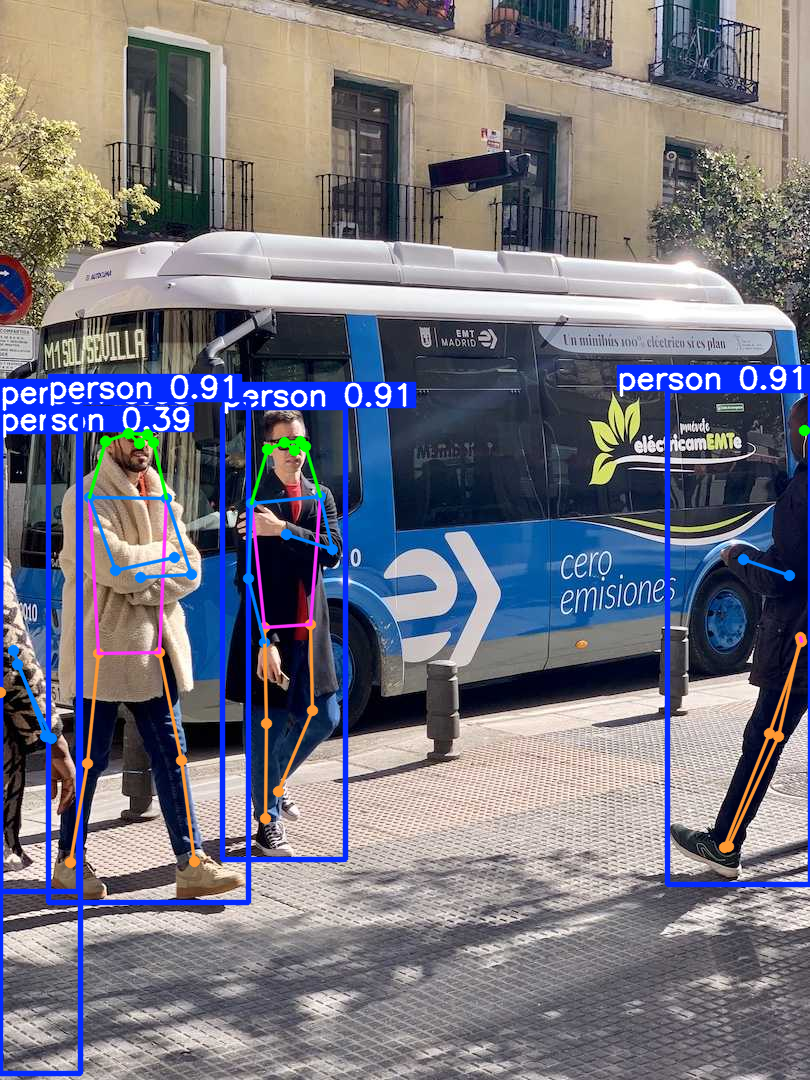

In [7]:
Image.fromarray(cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB))

## Generate Dataset of Keypoints

##### Keypoint extract

YOLOv8 pose estimation returns 17 keypoints:
* NOSE:           int = 0
* LEFT_EYE:       int = 1
* RIGHT_EYE:      int = 2
* LEFT_EAR:       int = 3
* RIGHT_EAR:      int = 4
* LEFT_SHOULDER:  int = 5
* RIGHT_SHOULDER: int = 6
* LEFT_ELBOW:     int = 7
* RIGHT_ELBOW:    int = 8
* LEFT_WRIST:     int = 9
* RIGHT_WRIST:    int = 10
* LEFT_HIP:       int = 11
* RIGHT_HIP:      int = 12
* LEFT_KNEE:      int = 13
* RIGHT_KNEE:     int = 14
* LEFT_ANKLE:     int = 15
* RIGHT_ANKLE:    int = 16

Since YOLO does not return the keypoints with their respective labels, we will create the following class for easy access to the data.

In [8]:
class GetKeypoint(BaseModel):
    NOSE:           int = 0
    LEFT_EYE:       int = 1
    RIGHT_EYE:      int = 2
    LEFT_EAR:       int = 3
    RIGHT_EAR:      int = 4
    LEFT_SHOULDER:  int = 5
    RIGHT_SHOULDER: int = 6
    LEFT_ELBOW:     int = 7
    RIGHT_ELBOW:    int = 8
    LEFT_WRIST:     int = 9
    RIGHT_WRIST:    int = 10
    LEFT_HIP:       int = 11
    RIGHT_HIP:      int = 12
    LEFT_KNEE:      int = 13
    RIGHT_KNEE:     int = 14
    LEFT_ANKLE:     int = 15
    RIGHT_ANKLE:    int = 16

get_keypoint = GetKeypoint()

##### Create a function for extracting keypoints while using the class above

In [9]:
def extract_keypoint(keypoint):
    # nose
    nose_x, nose_y = keypoint[get_keypoint.NOSE]
    # eye
    left_eye_x, left_eye_y = keypoint[get_keypoint.LEFT_EYE]
    right_eye_x, right_eye_y = keypoint[get_keypoint.RIGHT_EYE]
    # ear
    left_ear_x, left_ear_y = keypoint[get_keypoint.LEFT_EAR]
    right_ear_x, right_ear_y = keypoint[get_keypoint.RIGHT_EAR]
    # shoulder
    left_shoulder_x, left_shoulder_y = keypoint[get_keypoint.LEFT_SHOULDER]
    right_shoulder_x, right_shoulder_y = keypoint[get_keypoint.RIGHT_SHOULDER]
    # elbow
    left_elbow_x, left_elbow_y = keypoint[get_keypoint.LEFT_ELBOW]
    right_elbow_x, right_elbow_y = keypoint[get_keypoint.RIGHT_ELBOW]
    # wrist
    left_wrist_x, left_wrist_y = keypoint[get_keypoint.LEFT_WRIST]
    right_wrist_x, right_wrist_y = keypoint[get_keypoint.RIGHT_WRIST]
    # hip
    left_hip_x, left_hip_y = keypoint[get_keypoint.LEFT_HIP]
    right_hip_x, right_hip_y = keypoint[get_keypoint.RIGHT_HIP]
    # knee
    left_knee_x, left_knee_y = keypoint[get_keypoint.LEFT_KNEE]
    right_knee_x, right_knee_y = keypoint[get_keypoint.RIGHT_KNEE]
    # ankle
    left_ankle_x, left_ankle_y = keypoint[get_keypoint.LEFT_ANKLE]
    right_ankle_x, right_ankle_y = keypoint[get_keypoint.RIGHT_ANKLE]
    
    return [
        nose_x, nose_y,
        left_eye_x, left_eye_y,
        right_eye_x, right_eye_y,
        left_ear_x, left_ear_y,
        right_ear_x, right_ear_y,
        left_shoulder_x, left_shoulder_y,
        right_shoulder_x, right_shoulder_y,
        left_elbow_x, left_elbow_y,
        right_elbow_x, right_elbow_y,
        left_wrist_x, left_wrist_y,
        right_wrist_x, right_wrist_y,
        left_hip_x, left_hip_y,
        right_hip_x, right_hip_y,
        left_knee_x, left_knee_y,
        right_knee_x, right_knee_y,        
        left_ankle_x, left_ankle_y,
        right_ankle_x, right_ankle_y
    ]

##### Create our list of labels/classes based on the folders' names:

In [10]:
dataset_root = 'class-datasets/my-pose-classification-dataset'
pose_list = sorted((f for f in os.listdir(dataset_root) if not f.startswith(".")), key=str.lower) # to avoid included hidden files like .DS_Store
pose_list

['0', '1', '2']

##### Run through all the images of our dataset and extract the keypoints

In [11]:
dataset_csv = []
for pose in pose_list:

    image_path_list = glob.glob(f'{dataset_root}/{pose}/*.jpg')
    for image_path in image_path_list:
        # get image_name
        image_name = image_path.split('/')[-1]
        # read numpy image
        image = cv2.imread(image_path)
        # get height width image
        height, width = image.shape[:2]
        
        # detect pose using yolov8-pose
        results = model.predict(image, save=False)[0]
        # get the normalised values of x and y
        results_keypoint = results.keypoints.xyn.numpy()

        for result_keypoint in results_keypoint:
            if len(result_keypoint) == 17:
                keypoint_list = extract_keypoint(result_keypoint)
                # insert image_name, labe] in index 0,1 for the first 2 columns of the csv file
                keypoint_list.insert(0, image_name)
                keypoint_list.insert(1, pose)
                dataset_csv.append(keypoint_list)
        # break
    # break



0: 384x640 1 person, 148.7ms
Speed: 3.5ms preprocess, 148.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 166.7ms
Speed: 1.1ms preprocess, 166.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 135.6ms
Speed: 1.7ms preprocess, 135.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 137.5ms
Speed: 1.0ms preprocess, 137.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 135.5ms
Speed: 1.5ms preprocess, 135.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 141.5ms
Speed: 1.4ms preprocess, 141.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 138.3ms
Speed: 1.3ms preprocess, 138.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 123.2ms
Speed: 1.4ms preprocess, 123.2ms inference, 0.3ms postprocess per image at

##### Save the dataset_csv list in a csv file

In [12]:
# write csv
header = [
    'image_name',
    'label',
    # nose
    'nose_x',
    'nose_y',
    # left eye
    'left_eye_x',
    'left_eye_y',
    # right eye
    'right_eye_x',
    'right_eye_y',
    # left ear
    'left_ear_x',
    'left_ear_y',
    # right ear
    'right_ear_x',
    'right_ear_y',
    # left shoulder
    'left_shoulder_x',
    'left_shoulder_y',
    # right sholder
    'right_shoulder_x',
    'right_shoulder_y',
    # left elbow
    'left_elbow_x',
    'left_elbow_y',
    # rigth elbow
    'right_elbow_x',
    'right_elbow_y',
    # left wrist
    'left_wrist_x',
    'left_wrist_y',
    # right wrist
    'right_wrist_x',
    'right_wrist_y',
    # left hip
    'left_hip_x',
    'left_hip_y',
    # right hip
    'right_hip_x',
    'right_hip_y',
    # left knee
    'left_knee_x',
    'left_knee_y',
    # right knee
    'right_knee_x',
    'right_knee_y',
    # left ankle
    'left_ankle_x',
    'left_ankle_y',
    # right ankle
    'right_ankle_x',
    'right_ankle_y'
]

with open('class-datasets/my-pose-classification-dataset/poses_keypoints.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerows(dataset_csv)


Now, in our data/my-data folder, we should have our dataset of keypoints in a csv format, with one column with our labels, one (optional) column with the image_name and 34 columns with the 17 x 2 keypoints.

##### Get the first 5 rows of the csv file we just saved (without the image_name)

In [13]:
df = pd.read_csv('class-datasets/my-pose-classification-dataset/poses_keypoints.csv')
df = df.drop('image_name', axis=1)
df.head()

,label,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,0.499424,0.472427,0.542937,0.396961,0.462468,0.394208,0.600961,0.447014,0.414560,...,0.420865,0.971498,0.637712,0.779919,0.348256,0.742999,0.469817,0.830270,0.370147,0.804596
1,0,0.498795,0.472976,0.542529,0.397311,0.462499,0.393901,0.600813,0.446435,0.415404,...,0.422637,0.972520,0.636484,0.779905,0.347277,0.740608,0.467278,0.828791,0.366472,0.804371
2,0,0.500610,0.470773,0.544500,0.395134,0.463958,0.392337,0.602997,0.447188,0.416738,...,0.423064,0.971096,0.635627,0.779955,0.348611,0.741551,0.468780,0.831774,0.367555,0.805178
3,0,0.500440,0.470546,0.544361,0.395156,0.463843,0.392402,0.603066,0.446797,0.416689,...,0.422922,0.970828,0.635743,0.780208,0.348308,0.741928,0.468822,0.830511,0.367587,0.803960
4,0,0.498601,0.472903,0.542461,0.397401,0.462215,0.394062,0.601006,0.446900,0.415052,...,0.421990,0.972351,0.637010,0.779713,0.347286,0.741038,0.468818,0.828317,0.367778,0.804074


### Tasks:

**Task 1:** Run all the cells in this code to create your own dataset. Create a dataset with at least 3 classes, with at least 200 instances in each class.

**Task 2:** Move onto the code in [Week-4c-Train-pose-classifier.ipynb](Week-4c-Train-pose-classifier.ipynb) to train your classifier based on the yolo keypoints. 

**Bonus Task:** 

If you created the initial image datasets based on the provided [week-4a-collect-webcam-data.py](week-4a-collect-webcam-data.py) python script, you can also try recording small clips with your phone and then use `ffmpeg` on them to extract frames and organise them in the respective folders in your data. Then use this notebook again to create a different csv file for your classifier.
